______________
DAMI2 Project Report Code - Handling unbalanced datasets

2020 Jimmy Ljungman

This code imports a data set, preprocesses it, run a new sampling technique
called 'Unbalanced_bagging' and measure its performance against other sampling techniques
such as random oversampling and random undersampling.

Unbalanced_bagging will be measured against the other techniques using the metrics AUPRC and time complexity.

______________
Importing necessary libraries and setting global variables

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from scipy.stats import mode
from sklearn.metrics import average_precision_score
import random
from sklearn.metrics import plot_precision_recall_curve

RANDOM_SEED = 12345

In [108]:
original_df = pd.read_csv("datasets/diabetes.csv")


In [109]:
original_df.describe()
#weird that "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI" have zero values, imputate mean values

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [110]:
def imputation(data, columns):
    for c in columns:
         if c in data.columns:
             data[c].replace(0, np.nan,inplace=True)
             data[c].fillna(data[c].mean(), inplace=True)
    return data


In [111]:
original_df = imputation(original_df, ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"])

original_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<AxesSubplot:title={'center':'Plot over class imbalance'}>

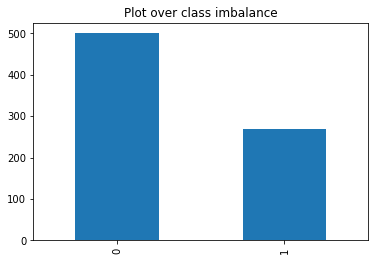

In [112]:
total_labels = original_df.Outcome.value_counts()
total_labels.plot(kind='bar', title='Plot over class imbalance')

In [113]:
#we can now split attributes and class label
X = original_df.drop('Outcome', axis=1)
y = original_df.Outcome

X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.400000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [114]:
def unbalanced_bagger(x, y, M = 1, sampling_techniques = None, base_estimator = None):
    if sampling_techniques is None:
        sampling_techniques = []
    if base_estimator is None:
        base_estimator = DecisionTreeClassifier()

    base_learners = []
    for i in range(M):

        rnd = np.random.choice(x.shape[0], size=x.shape[0])
        x_bootstrap = x.iloc[rnd,:]
        y_bootstrap = y.iloc[rnd]

        technique = random.randint(0,len(sampling_techniques)-1)
        x_sample, y_sample = sampling_techniques[technique].fit_sample(x_bootstrap,y_bootstrap)

        base_estimator.fit(x_sample,y_sample)
        base_learners.append(base_estimator)

    def predict(x):
        predictions = np.zeros([x.shape[0], len(base_learners)])
        for i in range(len(base_learners)):
            predictions[:,i] = base_learners[i].predict(x)
        return mode(predictions, axis=1)[0]
    return predict

In [ ]:
def unbalanced_bagger_two(x, y, M = 1, sampling_techniques = None, base_estimator = None):
    if sampling_techniques is None:
        sampling_techniques = []
    if base_estimator is None:
        base_estimator = DecisionTreeClassifier()

    base_learners = []
    for i in range(M):

        rnd = np.random.choice(x.shape[0], size=x.shape[0])
        x_bootstrap = x.iloc[rnd,:]
        y_bootstrap = y.iloc[rnd]

        technique = random.randint(0,len(sampling_techniques)-1)
        x_sample, y_sample = sampling_techniques[technique].fit_sample(x_bootstrap,y_bootstrap)

        base_estimator.fit(x_sample,y_sample)
        base_learners.append(base_estimator)

    def predict(x):
        predictions = np.zeros([x.shape[0], len(base_learners)])
        for i in range(len(base_learners)):
            predictions[:,i] = base_learners[i].predict(x)
        return mode(predictions, axis=1)[0],1

    return predict


In [115]:
def unbalanced_bagger_no_sampling(x, y, M = 1):
    #M = Amount of base_learners, x = train set, y = class labels
    base_learners = []
    for i in range(M):
        #boostrap replica
        rnd = np.random.choice(x.shape[0], size=x.shape[0])
        x_bootstrap = x.iloc[rnd,:]
        y_bootstrap = y.iloc[rnd]
        #train
        clf = DecisionTreeClassifier()
        clf.fit(x_bootstrap,y_bootstrap)
        base_learners.append(clf)

    def predict(x):
        predictions = np.zeros([x.shape[0], len(base_learners)])
        for i in range(len(base_learners)):
            predictions[:,i] = base_learners[i].predict(x)
        return mode(predictions, axis=1)[0]
    return predict

In [116]:
X_training,X_testing,y_training,y_testing, = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)
x_train, x_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.3, random_state=RANDOM_SEED)

In [117]:
ros = RandomOverSampler(random_state=RANDOM_SEED)
rus = RandomUnderSampler(random_state=RANDOM_SEED)
smote = SMOTE(random_state=RANDOM_SEED, sampling_strategy='minority')

sampling_techniques = [ros, rus,smote]
classifier = unbalanced_bagger(x_train, y_train, 10, sampling_techniques)

In [118]:
y_score = classifier(X_testing)

print("Data balanced by Unbalanced Bagger (1)")
print("\nValidation Results:")
print(classification_report(y_val, classifier(x_val)))
print("\nTest Results:")
print(classification_report(y_testing, y_score))

#true_labels, predicted_probs
average_precision = average_precision_score(y_testing, y_score)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(classifier, X_testing, y_testing)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

Data balanced by Unbalanced Bagger (1)

Validation Results:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       102
           1       0.54      0.48      0.51        60

    accuracy                           0.65       162
   macro avg       0.62      0.62      0.62       162
weighted avg       0.65      0.65      0.65       162


Test Results:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       158
           1       0.62      0.62      0.62        73

    accuracy                           0.76       231
   macro avg       0.72      0.72      0.72       231
weighted avg       0.76      0.76      0.76       231

Average precision-recall score: 0.50


ValueError: function should be a binary classifier

In [ ]:
sampling_techniques = [rus]
classifier = unbalanced_bagger(x_train, y_train, 10, sampling_techniques)

print("Data balanced by Unbalanced Bagger (2)")
print("\nValidation Results:")
print(classification_report(y_val, classifier(x_val)))
print("\nTest Results:")
print(classification_report(y_testing, classifier(X_testing)))

In [ ]:
classifier = unbalanced_bagger_no_sampling(x_train, y_train, 10)
print("unbalanced_bagger_no_sampling(1)")
print("\nValidation Results:")
print(classification_report(y_val, classifier(x_val)))
print("\nTest Results:")
print(classification_report(y_testing, classifier(X_testing)))

In [ ]:
clf = DecisionTreeClassifier(random_state=RANDOM_SEED)

def unbalanced_dataset_technique():
    clf.fit(x_train, y_train)
    return clf

def smote_technique():
    smote = SMOTE(random_state=RANDOM_SEED,sampling_strategy='minority')
    x_sample, y_sample = smote.fit_sample(x_train, y_train)
    clf.fit(x_sample,y_sample)
    return clf

def random_oversampling_technique():
    ros = RandomOverSampler(random_state=RANDOM_SEED)
    x_sample, y_sample = ros.fit_sample(x_train, y_train)
    clf.fit(x_sample, y_sample)
    return clf

def random_undersampling_technique():
    rus = RandomUnderSampler(random_state=RANDOM_SEED)
    x_sample, y_sample = rus.fit_sample(x_train, y_train)
    clf.fit(x_sample, y_sample)
    return clf

In [ ]:
#Train on original data
print("Original data")
classifier = unbalanced_dataset_technique()
print("\nValidation Results:")
print(classification_report(y_val, classifier.predict(x_val)))
print("\nTest Results:")
print(classification_report(y_testing, classifier.predict(X_testing)))

In [ ]:
#Train on SMOTE
print("Data balanced by SMOTE")
classifier = smote_technique()
print("\nValidation Results:")
print(classification_report(y_val, classifier.predict(x_val)))
print("\nTest Results:")
print(classification_report(y_testing, classifier.predict(X_testing)))

In [ ]:
#Train on Random Oversampling
print("Data balanced by Random Oversampling")
classifier = random_oversampling_technique()
print("\nValidation Results:")
print(classification_report(y_val, classifier.predict(x_val)))
print("\nTest Results:")
print(classification_report(y_testing, classifier.predict(X_testing)))

In [ ]:
#Train on Random Undersampling
print("Data balanced by Random Undersampling")
classifier = random_undersampling_technique()
print("\nValidation Results:")
print(classification_report(y_val, classifier.predict(x_val)))
print("\nTest Results:")
print(classification_report(y_testing, classifier.predict(X_testing)))